In [ ]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2
%aimport BayesianOptimization.bayes_opt.bayesian_optimization
%aimport BayesianOptimization.bayes_opt.helpers

In [44]:
import sys
import numpy as np 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import inspect
from matplotlib import gridspec

import warnings
warnings.filterwarnings('ignore')from BayesianOptimization.bayes_opt.bayesian_optimization import BayesianOptimization

# Brian Function Simulation

From the paper I read this week, they use Brian function as testing function for global optimization problem. As you can observe from contour map above, we have 3 global minimum and no local minimum. 

In [3]:
# Numerical decisions
N = 1000
x1 = np.linspace(-5, 10, N, endpoint=True)
x2 = np.linspace(0, 15, N, endpoint=True)

def Brainfunction(x1,x2):
    # Parameters of the function
    PI = 3.14159265359
    a = 1;
    b = 5.1/(4*pow(PI,2));
    c = 5/PI;
    r = 6;
    s = 10;
    t = 1/(8*PI);
    f = a*(x2 - b*x1**2 + c*x1 -r)**2 + s*(1-t)*np.cos(x1) + s
    return f*(-1)

In [4]:
sns.set(context="notebook", style="dark",
        rc={"axes.axisbelow": False})
def contourFunction(X, Y, Z, nbins=50):
    levels=mpl.ticker.MaxNLocator(nbins=nbins).tick_values(Z.min(),Z.max())
    plt.figure(figsize=(20,20))

    plt.subplot(2,1,1)
    plt.contourf(X,Y,Z,levels=levels ,zorder=0,cmap=plt.get_cmap('rainbow_r'))
    plt.colorbar()

    plt.subplot(2,1,2)
    cp = plt.contour(X, Y, Z,levels=levels,cmap=plt.get_cmap('rainbow_r'))
    plt.clabel(cp, inline=True, fontsize=20)
    plt.colorbar()
    plt.grid('on')
    plt.title('Brinan Function Contour plot')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()
    
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

Brian Function

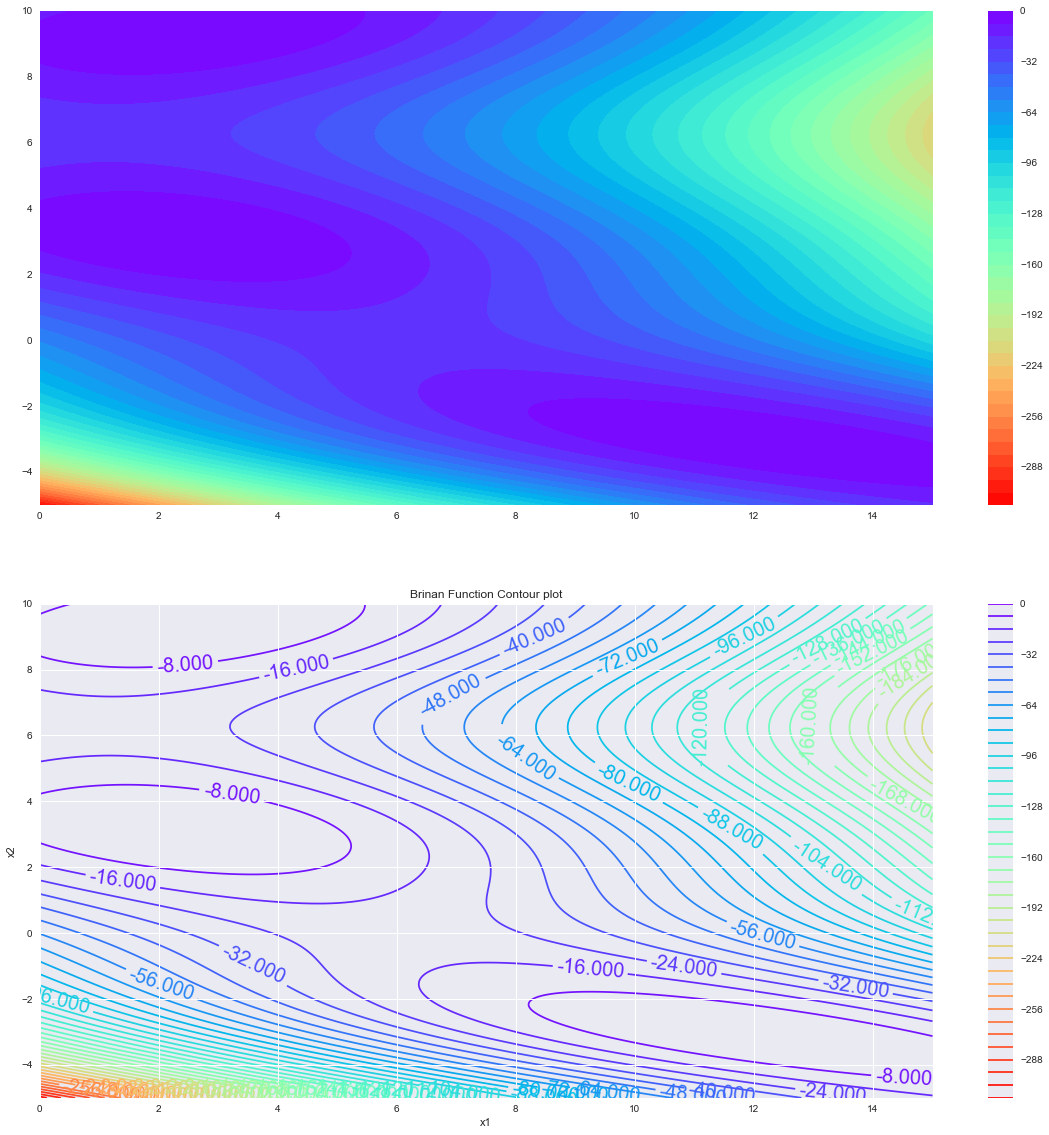

In [5]:
X,Y = np.meshgrid(x1,x2)
Z = Brainfunction(X,Y)
printmd('Brian Function')
contourFunction(Y,X,Z,50)

# Bayesian Simulation

## Initial knowledge and visualization
In this example I will use the Expected Improvement (EI) as our utility function. It does not have free parameter However, EI has 2 components as I showed in the summary which control the balance between exploration and exploitation **automatically**. Additionally I will use the **squared-exponential kernel** in our Gaussian Process.

In [21]:
def gpPredictFix(x):
    return np.array([x[i] for i in x.keys()]).T

def posterior(bo, x):
    # Fit gaussian process
    bo.gp.fit(bo.X, bo.Y)
    # Create predict value (mu,sigma)
    Xinput = gpPredictFix(x)
    return bo.gp.predict(Xinput, return_std=True)

In [22]:
def plot_gp(bo, x, y, nbins=50, init= False,iters=5):
    
    fig = plt.figure(figsize=(20, 6))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)))
    
    gs = gridspec.GridSpec(1, 2)#,height_ratios=[1,1])
    #axTar = plt.subplot(gs[0, 0])
    axPre = plt.subplot(gs[0, 0])
    acq = plt.subplot(gs[0, 1])
    mu, sigma = posterior(bo, x)

    size = int(np.sqrt(len(x['x1'])))
    levels=mpl.ticker.MaxNLocator(nbins=nbins).tick_values(y.min(),y.max())
    # Target
    #cp = axTar.contour(x['x1'].reshape(size,size), x['x2'].reshape(size,size), y, 
    #                   levels=levels,cmap=plt.get_cmap('rainbow_r'))
    #plt.clabel(cp, inline=True, fontsize=10)
     
    # Prediction
    cp = axPre.contour(x['x2'].reshape(size, size), x['x1'].reshape(size, size), mu.reshape(size, size) 
                  , levels=levels, cmap=plt.get_cmap('rainbow_r'))
    plt.clabel(cp, inline=True, fontsize=10)
    # PLOT SAMPLE POINT
    axPre.plot(bo.X[:,1], bo.X[:,0], 'D', markersize=6, label=u'Observations', color='r')
    if (init == False):
        axPre.plot(bo.X[:,1][-iters:], bo.X[:,0][-iters:], 'D', markersize=8, label=u'New Observations', color='g')
        
   
    # Utility Map
    Xinput = gpPredictFix(x)
    utility = bo.util.utility(Xinput, bo.gp, np.max(mu))
    levels=mpl.ticker.MaxNLocator(nbins=10).tick_values(utility.min(),utility.max())
    cp = acq.contour(x['x2'].reshape(size, size), x['x1'].reshape(size, size), utility.reshape(size, size), 
                label='Utility Function', levels=levels, cmap=plt.get_cmap('rainbow'))
    plt.clabel(cp, inline=True, fontsize=10)
    
    # Next sample Point 
    maxUtilityPoint = Xinput[np.argmax(utility)]
    acq.plot(maxUtilityPoint[1], maxUtilityPoint[0], '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='y', markeredgewidth=1)
    
    axPre.legend(loc=1, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=1, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1,top=0.95)
    plt.show()

##### Ploting data

In [8]:
X1sample = X.flatten()
X2sample = Y.flatten()
Z = Brainfunction(X,Y)
Xsample = {'x1':X1sample,'x2': X2sample}

##### Define the  Bayesian Optimization function - initialization data
In **squared-exponential kernel**, it is parameterized by 3 parameters **(signal variance, length scale and noise variance)**. At the beginning, I set those parameters as below. Addtionally, I probe 10 points at random, we can fit a Gaussian Process and start the bayesian optimization procedure.

In [46]:
# Hyper parameter
alpha = 1.0
lengthscale = 1
noise = 1e-4 

Initialization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
    1 | 00m00s |  -28.77112 |   -0.1672 |    9.3199 | 
    2 | 00m00s |  -49.53142 |    7.6042 |    7.4633 | 
    3 | 00m00s |  -73.74880 |    6.2021 |    8.4589 | 
    4 | 00m00s |   -1.55174 |    9.2268 |    1.3301 | 
    5 | 00m00s |   -2.04170 |    2.6526 |    3.4073 | 
    6 | 00m00s |  -78.35806 |   -4.3381 |    6.8580 | 
    7 | 00m00s |  -64.92703 |    2.5965 |   10.6844 | 
    8 | 00m00s |  -74.72231 |    8.9256 |   10.6391 | 
    9 | 00m00s |   -2.01197 |   -2.6344 |   10.4527 | 
   10 | 00m00s |  -71.94733 |   -3.4460 |    4.5861 | 
Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 


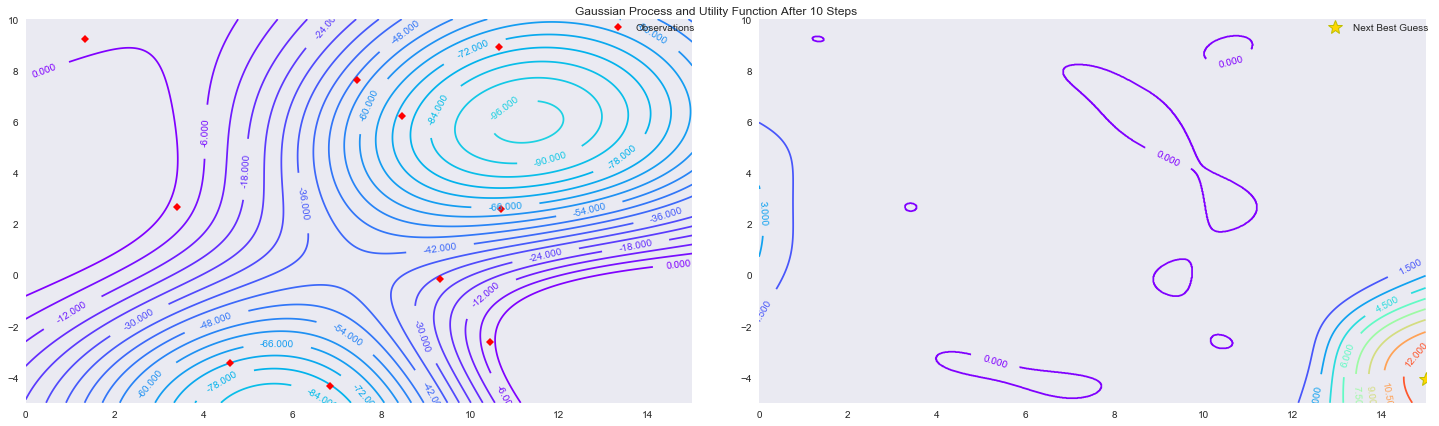

In [34]:
bo = BayesianOptimization(Brainfunction, {'x1': (-5, 10), 'x2': (0,15)})
bo.set_gaussianprocess(alpha, lengthscale, noise)
bo.maximize(init_points=10, n_iter=0, acq='ei')
plot_gp(bo,Xsample,Z,60,init=True)

The graph on the left shows you the target function simulated by Gaussian Process and the others indicate the utility map. As you can see that, initial knowledge with 10 points is not enough to represent our target function. A **star** point on the utility map indicate the next observation we should do experiments.

## Simulate Bayesian Optimization by 10 steps

This part just want to show you how bayesian optimization runs in our problem. The process can be summarized into some simple step:

- Given observed values $f(x)$, update the posterior expectation of $f$ using the GP model.
- Find $x_{new}$ that maximises the EI: $x_{new}= argmax$ $EI(x)$
- Compute the value of $f$ for the point $x_{new}$.

This procedure is either repeated for a pre-specified number of iterations, or until convergence.

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
   11 | 00m05s |   -3.03545 |   -3.6925 |   14.7413 | 


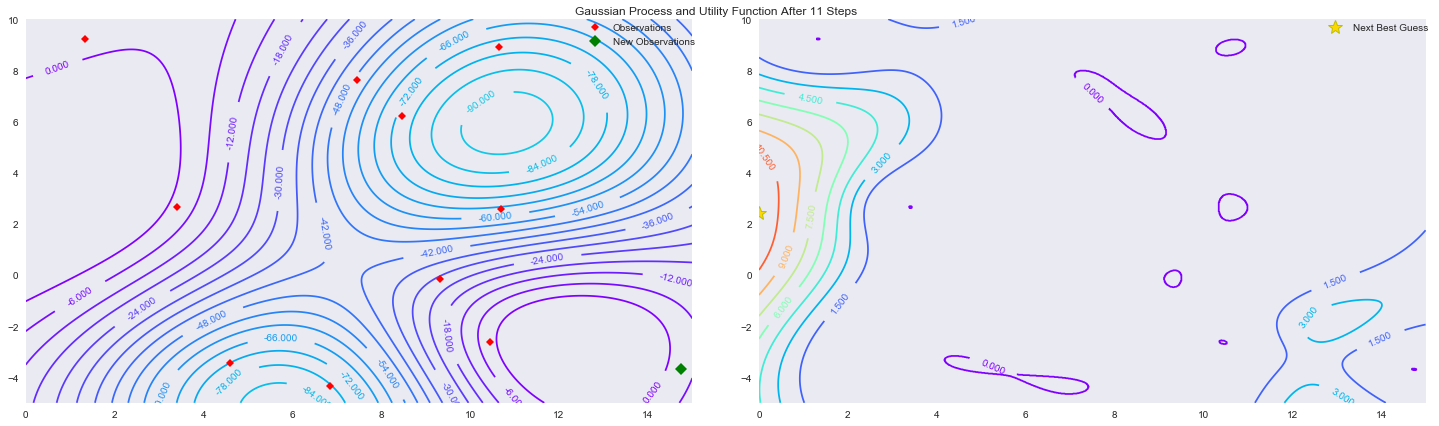

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
   12 | 00m06s |   -9.19318 |    2.6061 |    0.0000 | 


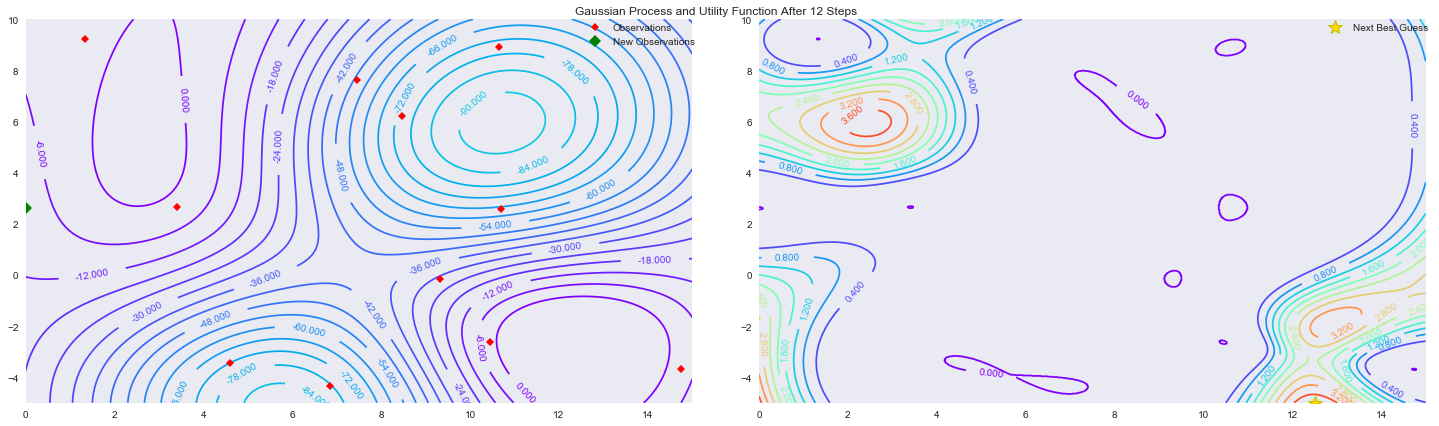

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
   13 | 00m06s |   -0.99774 |   -2.9264 |   12.3789 | 


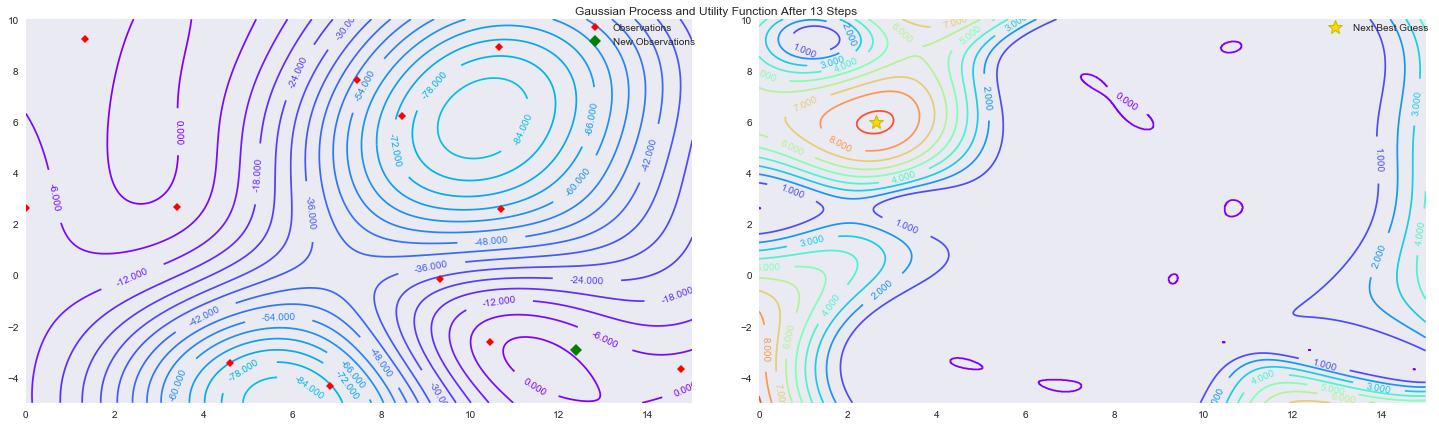

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
   14 | 00m06s |  -21.44036 |    5.9562 |    2.6355 | 


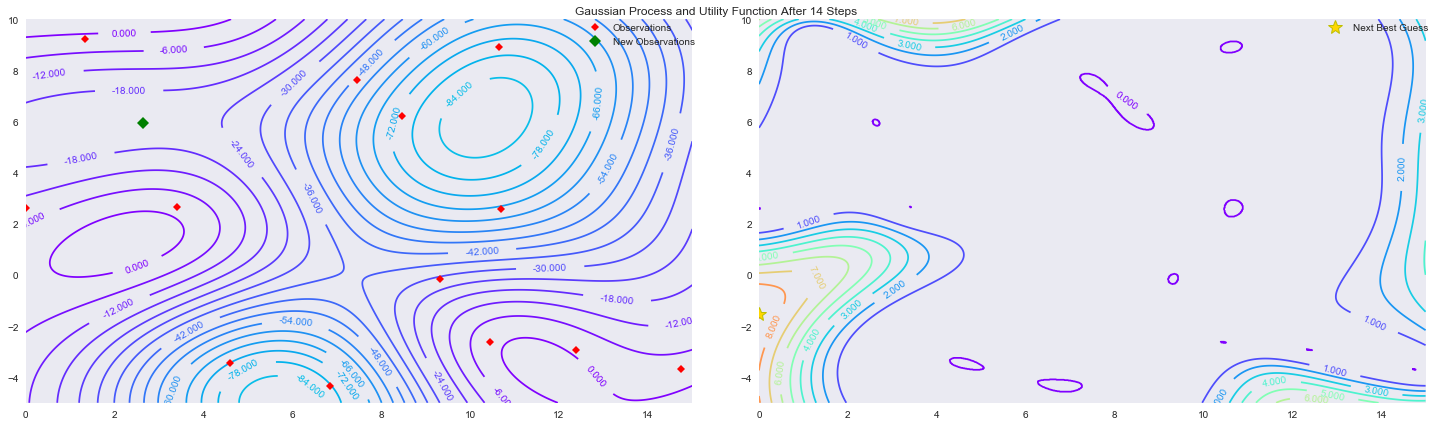

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
   15 | 00m06s |  -83.76476 |   -1.4084 |    0.0000 | 


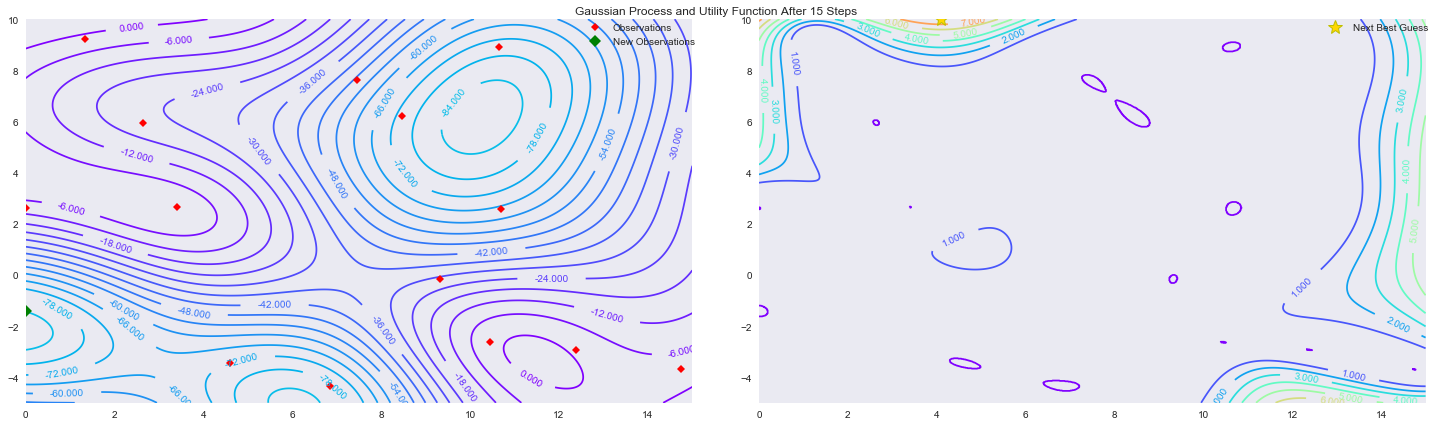

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
   16 | 00m06s |  -10.96089 |   10.0000 |    0.0000 | 


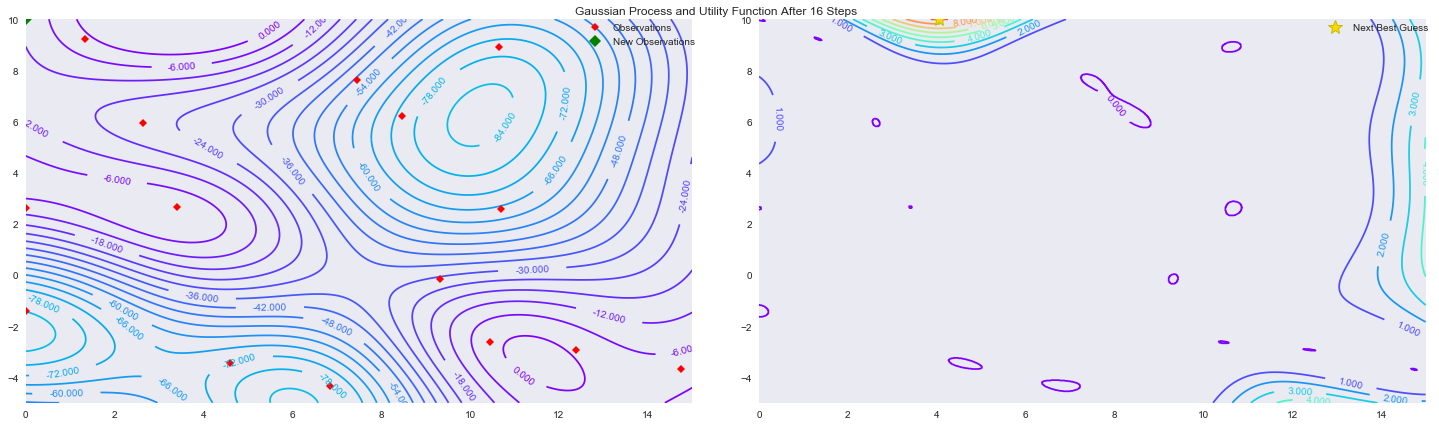

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
   17 | 00m07s |   -2.73260 |   10.0000 |    3.8915 | 


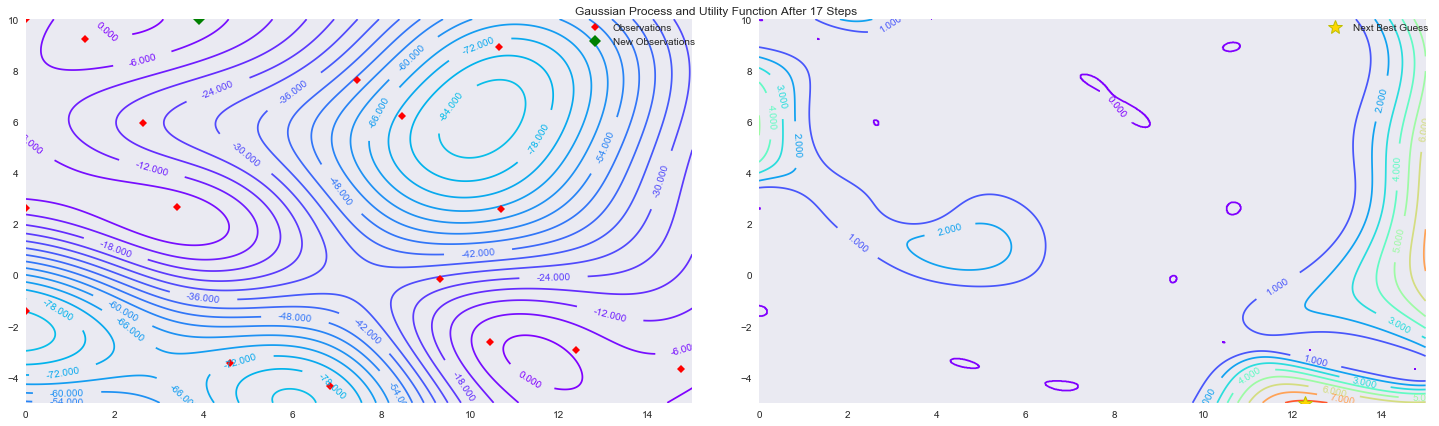

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
   18 | 00m07s |  -36.62605 |   -5.0000 |   12.2984 | 


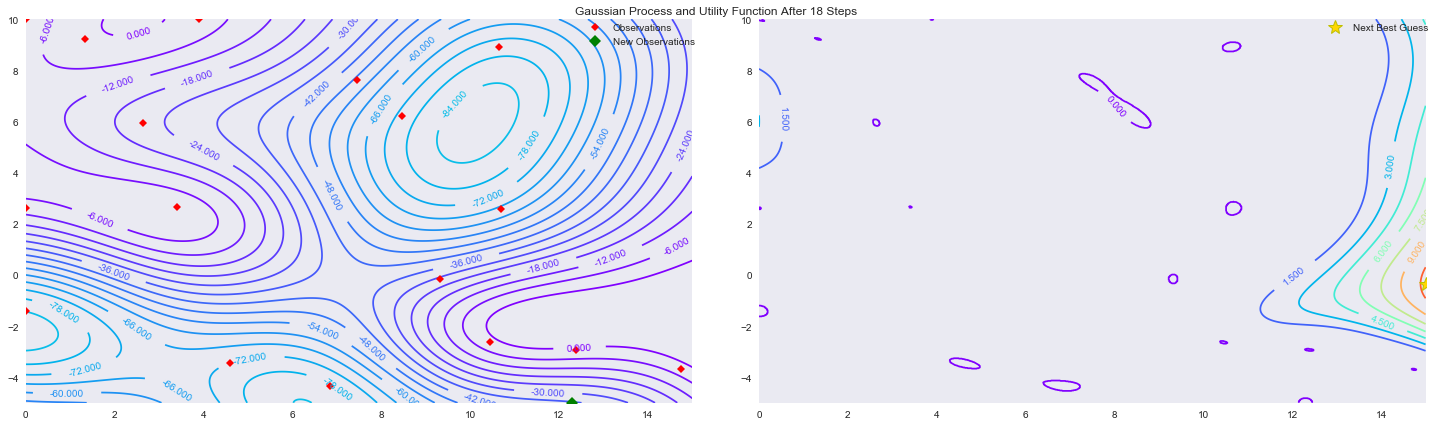

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
   19 | 00m07s |  -79.89426 |   -0.6599 |   15.0000 | 


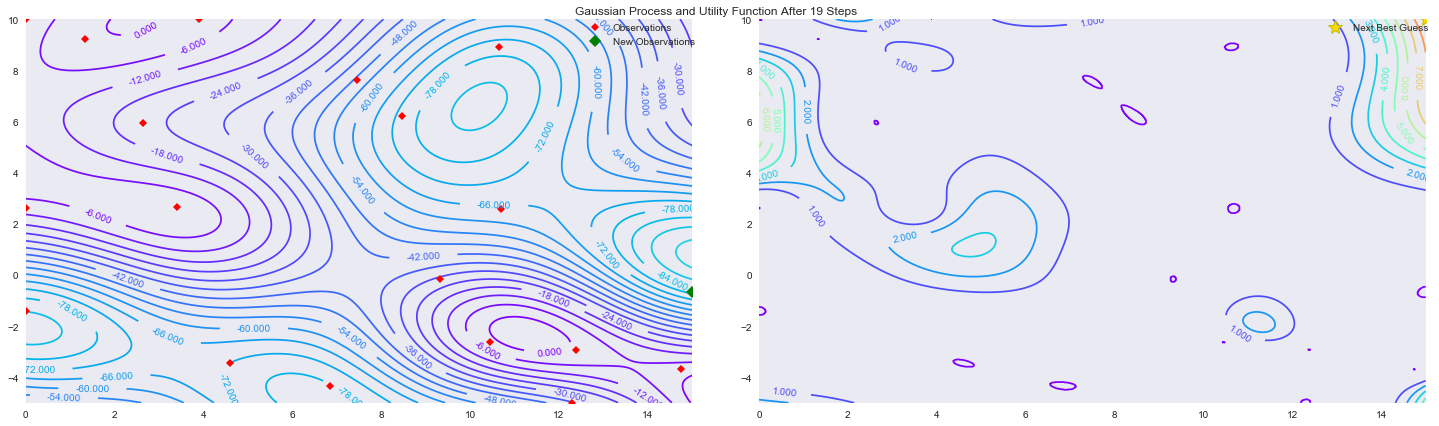

Bayesian Optimization
-----------------------------------------------------
 Step |   Time |      Value |        x1 |        x2 | 
   20 | 00m07s | -145.87219 |   10.0000 |   15.0000 | 


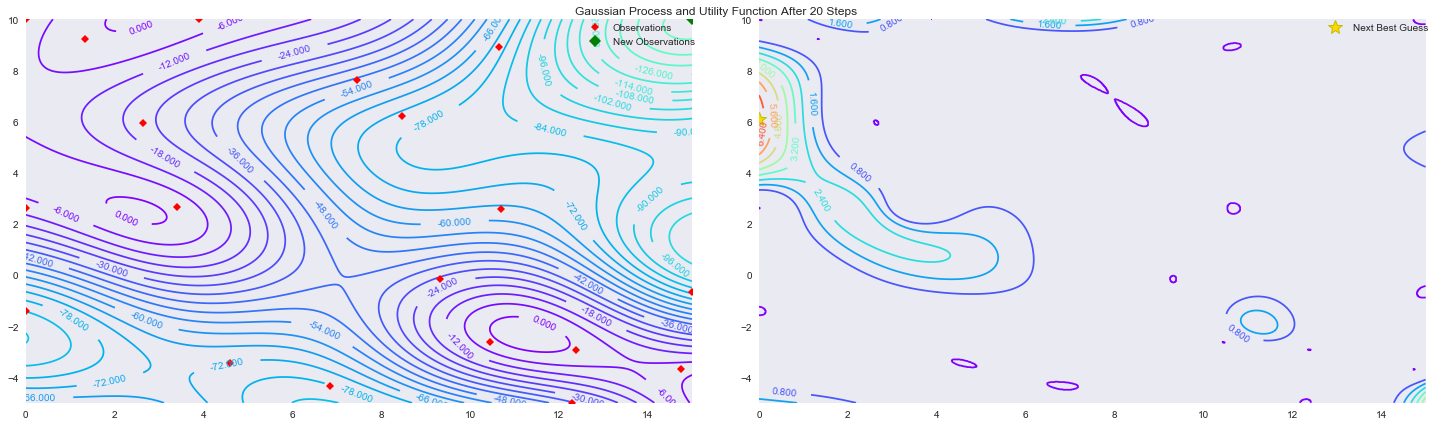

In [35]:
for i in range(10):
    bo.maximize(init_points=0, n_iter=1, acq='ei')
    plot_gp(bo,Xsample,Z,60, iters=1)

##### Comment
Sometimes, you can observe that the next obsevation point is not the suggested point because it is useless if 2 data points are same or too close to each others. In that case, I will re-sample a new point.

In conclusion, after just a few points the algorithm was able to get close to the 3 true maximum. It is important to say that the trade off between exploration (exploring the parameter space) and exploitation (probing points near the current known maximum) is **fundamental** to a succesful bayesian optimization. 

## Bayesian Optimization Convergence 

In this part, I want to observe how many iterations we need for the simulation can simulate well our target function. From the result, I saw that we only need around 30 iterations to converge to true optimal points ( 3 global maximization in our case). 

In [47]:
def plot_gp_simulation(bo, x, y, ax, iters, nbins=50):
    ax.set_title('Gaussian Process After {} Iterations'.format(iters))
    
    size = int(np.sqrt(len(x['x1'])))
    levels=mpl.ticker.MaxNLocator(nbins=nbins).tick_values(y.min(),y.max())
    mu, sigma = posterior(bo, x)
    
    # Prediction
    cp = ax.contour(x['x2'].reshape(size, size), x['x1'].reshape(size, size), mu.reshape(size, size) 
                  , levels=levels, cmap=plt.get_cmap('rainbow_r'))
    plt.clabel(cp, inline=True, fontsize=6)
    # PLOT SAMPLE POINT
    ax.plot(bo.X[:,1], bo.X[:,0], 'D', markersize=4, label=u'Observations', color='r')
   
    ax.legend(loc=1, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

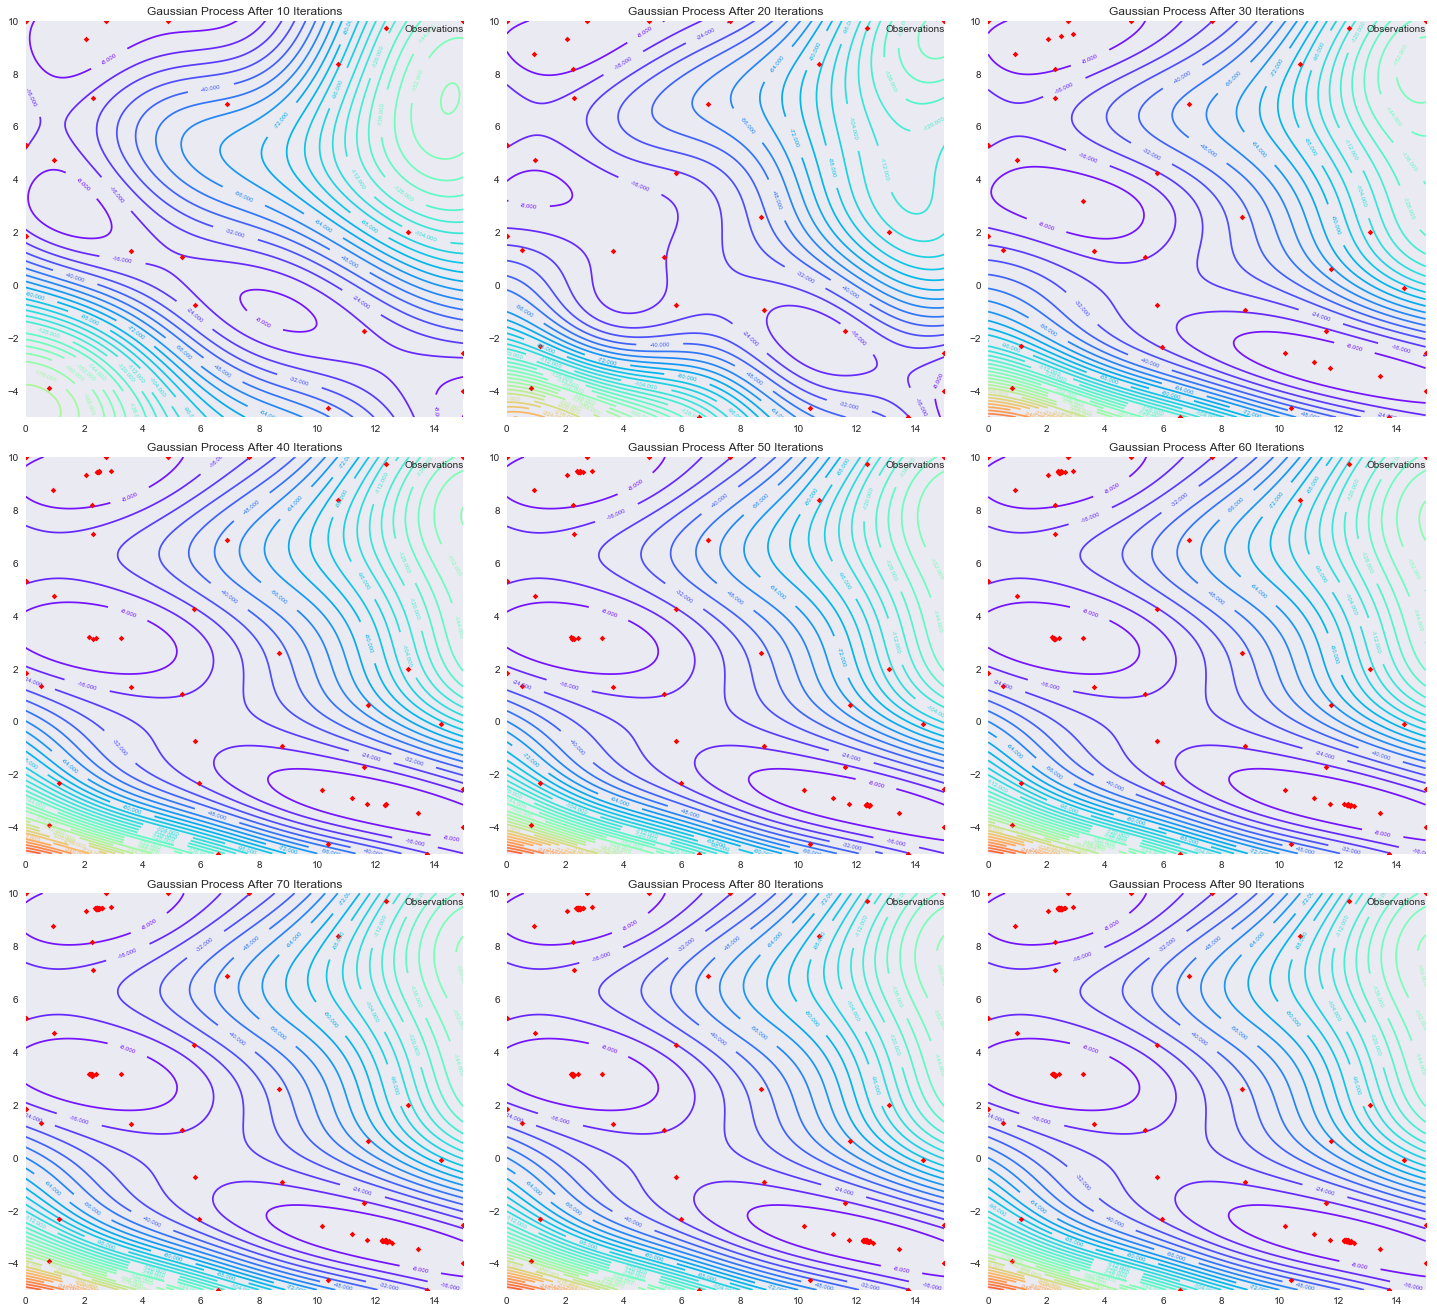

In [49]:
bo = BayesianOptimization(Brainfunction, {'x1': (-5, 10), 'x2': (0,15)},verbose= False)
bo.set_gaussianprocess(alpha, lengthscale, noise)
bo.maximize(init_points=10, n_iter=0, acq='ei')

gs_height = 3
gs_width = 3
gs = gridspec.GridSpec(gs_height, gs_width)
plt.figure(figsize=(20,20))
for i in range(9):
    bo.maximize(init_points=0, n_iter=10, acq='ei')
    plot_gp_simulation(bo, Xsample, Z, plt.subplot(gs[int(i/gs_width), i%gs_width]), (i+1)*10)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1,top=0.9)
plt.show()